# Carga de datos

La ventaja de haber almacenado los ficheros en el apartado anterior es que ahora se pueden importar sin necesidad de utilizar de nuevo el pipeline, lo cual supone un ahorro de tiempo considerable. Por ello, lo primero conecto el notebook a google drive y lo cargo los datos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Datos de entrenamiento
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_train_pipeline.csv",sep=';')
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                              tokens  cardinality  rating_note
0  ['loathe', 'american', 'detective', 'drama', '...          133          5.0
1  ['storyline', 'great', 'look', 'last', 'chapte...           68          3.0
2  ['well', 'least', 'first', 'film', 'bearable',...           24          3.0
3  ['whilst', 'near', 'best', 'crosby', 'film', '...           29          5.0
4  ['best', 'season', 'far', 'cast', 'outdone', '...           12          5.0
Dimensión conjunto de entrenamiento (98088, 3)


In [ ]:
#Datos de test
import pandas as pd
test_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_test_pipeline.csv",sep=';')
print(test_data.head())
print("Dimensión conjunto de test",test_data.shape)

                                              tokens  cardinality  rating_note
0  ['say', 'strongly', 'enough', 'one', 'man', 'p...           21          5.0
1  ['wonder', 'guy', 'hop', 'would', 'influence',...           98          1.0
2  ['movie', 'boring', 'mean', 'real', 'boring', ...           17          1.0
3  ['interest', 'movie', 'good', 'act', 'reasonab...           14          3.0
4  ['kid', 'like', 'movie', 'probably', 'well', '...           14          4.0
Dimensión conjunto de test (24543, 3)


#Primer modelo: Modelo SVM

El objetivo de la práctica es generar dos modelos distintos que sean clasificadores binarios: aquellas reseñas cuya nota sea tres o más serán categorizadas como uno y las que sean inferior a tres, serán categorizadas como cero. La idea es utilizar dos modelos y comparar sus resultados para poder determinar cual de los dos es mejor.

El primer modelo que se va a programar es un modelo basado en bolsa de palabras (bag-of-words). Existen varios modelos que se pueden utilizar con bolsa de palabras pero en mi opinión creo que los dos más destacados son SVM y Naive-Bayes. En mi caso me voy a decantar por el primero por los siguientes motivos:

*   La principal diferencia entre ambos modelos es que el modelo Naive-Bayes asume independencia entre características del corpus por lo que a veces no captura correctamente las relaciones semánticas complejas. Desde mi punto de vista,en el lenguaje es muy importante el contexto y creo que en NLP no es realista asumir independencia entre las características.

*   Por su parte, SVM utiliza representaciones vectoriales de palabras (por ejemplo, TF-IDF) para clasificar texto. Por medio de estas representaciones, el modelo busca un hiperplano que intente separar las palabaras en diferentes clases por lo que este modelo captura mejor la relación semántica.

*   Asimismo, debido a esta suposición de independecia entre características, los modelos SVM tienden a ser más robustos frente al ruido que los modelos de Naive-Bayes.

Por todo ello, el primer modelo que se va a programar es un modelo tipo SVM. Como se ha indicado durante las razones de la elección, este tipo de modelo utiliza representaciones vectoriales para intentar clasificar las palabras entre clases. Por ello, lo primero que se debe decidir es que tipo de representación vectorial se quiere utilizar.

Existen distintas representaciones vectoriales (one-hot encoded, count vectorizer, TF-IDF) y todas ellas tienen sus ventajas y desventajas. Esta primera decisión es importante ya que en función de como se representen los datos, el modelo tendrá un rendimiento distinto. En mi caso de primeras voy a decantarme por la representación TF-IDF porque, aunque sea menos interpretativo que las dos primeras, creo que captura mejor la importancia relativa de las palabaras en el documento y en el corpues y además mitiga el efecto de las palabras que comunes que no son informativas. Por ello, procedo a vectorizar los tokens.

Para vectorizar las palabras voy a utilizar la función TdifVectoirzer pero especificando algunos parámetos porque deseo tener la mejor representación posible dentro de lo posible.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creo un objeto TfidfVectorizer con parámetros personalizados
#ngram_range=(1, 2): esto lo hago porque quiero que capture mejor la relación entre palabras contiguas.
#max_features=1000: limito la dimensión a 1000 para reducir la dimensionalidad
#max_df=0.95, min_df=5: elimino las palabras muy comunes (superiores al 95%) y las palabras muy poco comunes (menos del 5%)

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, max_df=0.95, min_df=5)

# Transformo los datos de entrenamiento
X_train = tfidf.fit_transform(train_data['tokens'])
print('Dimensión de los vectores de train:',X_train.shape)

# Transformo los datos de prueba utilizando el mismo vectorizador ajustado al conjunto de entrenamiento
X_test = tfidf.transform(test_data['tokens'])
print('Dimensión de los vectores de test:',X_test.shape)


Dimensión de los vectores de train: (98088, 1000)
Dimensión de los vectores de test: (24543, 1000)


Seguidamente, categorizo cada reseña en las dos posibles categorías y genero las etiquetas para el entrenamiento.

*   Reseña con nota 3 o más: Categoría 1
*   Reseña con nota 1 o 2: Categoría 0

La categoría 1 serán reseñas positivas y la cero seran reseñas negativas.

In [ ]:
# Etiquetas de entrenamiento
train_labels = train_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)
train_labels_counts = train_labels.value_counts()

print("Número de etiquetas de train de la categoría 1:", train_labels_counts[1])
print("Número de etiquetas de train de la categoría 0:", train_labels_counts[0])

# Etiquetas de prueba
test_labels = test_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)
test_labels_counts = test_labels.value_counts()
print("Número de etiquetas de test de la categoría 1:", test_labels_counts[1])
print("Número de etiquetas de test de la categoría 0:", test_labels_counts[0])

Número de etiquetas de train de la categoría 1: 85007
Número de etiquetas de train de la categoría 0: 13081
Número de etiquetas de test de la categoría 1: 21216
Número de etiquetas de test de la categoría 0: 3327


Como puede apreciarse los datos están muy desbalanceados, esto es importante tenerlo en cuenta a la hora de ofrecer los resultados. Tanto en train como en test el 87% de los datos son de categoría 1.

Con todo preparado, realizo el entrenamiento.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Modelo SVM
svm_model = SVC(kernel='rbf', gamma=0.1)  # Voy a utilizar un kernel radial porque creo que las relaciones entre los tokens puede ser compleja y no lineal.

# Entreno el modelo SVM
svm_model.fit(X_train, train_labels)

# Predicciones del modelo
predicciones = svm_model.predict(X_test)


Voy a pintar la matriz de confusión para poder tener una idea gráfica del rendimiento del modelo.

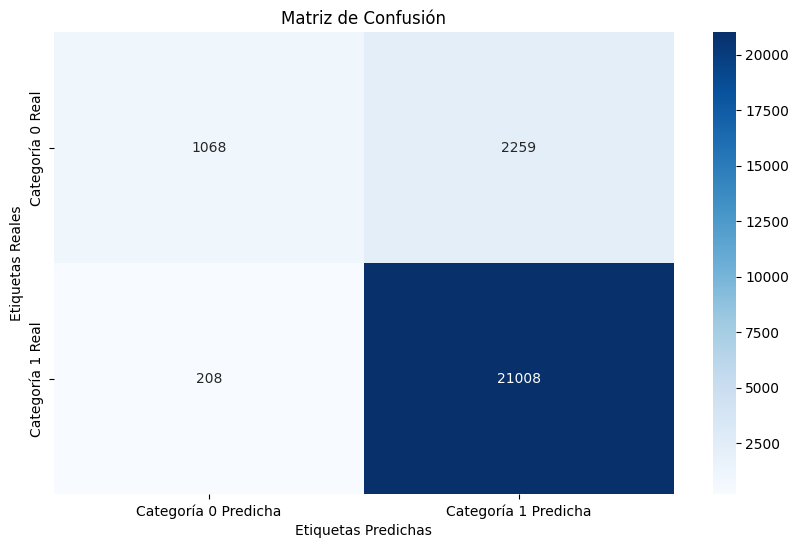

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculo la matriz de confusión
conf_matrix = confusion_matrix(test_labels, predicciones)
df_visualization = pd.DataFrame(conf_matrix, index=['Categoría 0 Real', 'Categoría 1 Real'], columns=['Categoría 0 Predicha', 'Categoría 1 Predicha'])

# Visualizo la matriz de confusión
plt.figure(figsize=(10, 6))
sns.heatmap(df_visualization, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.show()



La matriz de confusión ofrece unas conclusiones que son interesantes comentar:

*   En primer lugar, se puede observar como el rendimiento del modelo para categoría 1 es mucho mejor que para categoría 2. Esto era algo que se podía suponer ya que los datos están muy desbalanceados (el 87% son de categoría 1). Como consecuencia, el modelo es bastante efectivo para clasificar la categoría 1 ya que el número de verdaderos positivos (21008) es significativamente mayor que el número de falsos negativos (208).

*  Sin embargo, el modelo parece tener dificultades para clasificar la categoría 0, ya que el número de falsos positivos (2259) es mayor que el número de verdaderos negativos (1068).

Como consecuencia es posible afirmar que el modelo parece estar sesgado hacia la categoría 1 y muestra un rendimiento deficiente en la clasificación de la categoría 0. Por lo tanto se podría interpretar que el modelo está dando más importancia a la categoría 1 y está pasando por alto la categoría 0 en cierta medida.

Voy a calcular las métricas de clasificación para poder hacerse una idea del rendimiento global del modelo.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Precisión
accuracy = accuracy_score(test_labels, predicciones)

# Sensibilidad
recall = recall_score(test_labels, predicciones)

# Especifidad
tn, fp, fn, tp = confusion_matrix(test_labels, predicciones).ravel()
specificity = tn / (tn + fp)

# F1
f1 = f1_score(test_labels, predicciones)

# Imprimir las métricas
print("Precisión (Accuracy):", accuracy)
print("Sensibilidad (Recall):", recall)
print("Especificidad (Specificity):", specificity)
print("F1", f1)


Precisión (Accuracy): 0.8994825408466772
Sensibilidad (Recall): 0.9901960784313726
Especificidad (Specificity): 0.32100991884580704
F1 0.9445406110199401


Las métricas obtenidas ofrecen la misma conclusión que la matriz de conclusión. Al final el modelo está sesgado hacia la categoría 1 por lo que su sensibilidad es muy elevada y dado que en los datos de entrenamiento y test, la categoría predominate es la categoría 1, se obtiene un accuracy también muy elevado. Sin embargo, el valor de la especifidad muestra claramente que este modelo es malo para clasificar las reseñas de categoría 0. Por último, debido a tener una precisión y una sensibilidad tan alta, se obtiene un valor de F1 que también es elevado.

El objetivo de esta práctica no es tanto el obtener un modelo con un rendimiento perfecto, sino más bien el mostrar el procedimiento para obtener el resultado. Es por eso que voy a dar por válido este resultado. Sin embargo, si se quisiera ser puristas sería interesante comprobar como actuaría el modelo con unos datos balanceados o si se podría utilizar otro tipo de kernel para obtener un mejor resultado.

# Segundo modelo: Modelo LSTM

El segundo modelo que se va a implementar va estar basado en DeepLearning. El motivo por el que he decidido esto es debido a que me parecía interesante aprender modelos tanto basados en Machine Learning como en DeepLearning y como la mejor forma de aprender es intentándolo, por eso me he animado a programar un modelo basado en DL.

Dentro de los modelos de DL, existen varias modelos entre los que destacan las redes recurrentes (RNN), las redes neuronales de memoria a largo plazo (LSTM) y las redes neuronales de puertas recurrentes (GRU). Todas ellas tienen en común que se utilizan para modelar datos secuenciales pero no obstante, las tres se diferencian en ciertos aspectos.

*   Las redes RNN son redes que tienen conexiones retroalimentadas que les permiten mantener un estado interno o memoria mientras procesan secuencias de datos. Sin embargo, el principal problema de estas redes es que pueden sufrir el desvanecimiento del gradiente y esto puede ocasionar que en secuencias largas la información se pueda perder durante el entrenamieno.

*   Por su partes las redes de memoraio a largo plazo (LSTM) son una extensión de las RNN pero con alguna diferencia en su arquitectura para que el problema del desfallecimiento del gradiente no ocurra. Estas redes poseen celdas de memoria y estructuras de puertas para determinar que información se recuerda y cuando permitiéndoles aprender dependencias a largo plazo.

*   Por último, las redes de puertas recurrentees (GRU), son parecidas a las LSTM pero computacionalmente más eficientes ya que son más simples. Estas redes poseen menos parámetros que las LSTM por lo que hace que sean más fáciles de entrenar.

En este caso, como se ha visto durante el preprocesamiento, las reseñas poseen distintas longitudes, desde unas pocas palabras hasta 400. Es por eso como existen secuencias que son largas, las redes recurrentes las descarto dado que no quiero que ocurra el problema del desvanecimiento del gradiente. Por otra parte, frente a las otras dos opciones, me decanto por las redes LSTM porque aunque son más computacionalmente costosas, creo que es la mejor opción ya que este tipo de redes procesan mejor las secuencias largas que las GRU. Por ello, a continuación, se procede a implentar la red.


El primer paso es vectorizar los tokens para que el modelo pueda interpretar las palabras. Para ello se puede hacer de dos formas: o bien se utiliza la función word2vec como se ha realizado en el apartado 1 o bien se utiliza la capa embedding con el modelo. La principal diferencia entre ambos enfoques es que por un lado en el caso de word2vec se generan los vectores por un lado y luego con esos vectores se entrena el modelo (los vectores son independientes al modelo) y por el otro lado, la capa embedding es una capa perteneciente al modelo y por lo tanto los vectores se van generando durante el entrenamiento por lo que sus pesos se van ajustando conforme se ajusta el peso de las redes. Ambas opciones se podrían utilizar, pero para este ejercicio dado que he implementado en el apartado uno la opción de word2vec, es la que voy a utilizar.

En primer lugar importo los datos

In [ ]:
#Datos de entrenamiento
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_train_pipeline.csv",sep=';')
train_data['tokens'] = train_data['tokens'].apply(eval)

#Datos de test
import pandas as pd
test_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_test_pipeline.csv",sep=';')
test_data['tokens'] = test_data['tokens'].apply(eval)

# Categorizo train
train_data['category'] = train_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)


# Categorizo test
test_data['category'] = test_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)

print("Dimensión conjunto de test",test_data.shape)
print("Dimensión conjunto de entrenamiento",train_data.shape)
print(train_data.head())
print(test_data.head())

Dimensión conjunto de test (24543, 4)
Dimensión conjunto de entrenamiento (98088, 4)
                                              tokens  cardinality  \
0  [loathe, american, detective, drama, ending, a...          133   
1  [storyline, great, look, last, chapter, love, ...           68   
2  [well, least, first, film, bearable, glorious,...           24   
3  [whilst, near, best, crosby, film, welcome, se...           29   
4  [best, season, far, cast, outdone, kathy, bate...           12   

   rating_note  category  
0          5.0         1  
1          3.0         1  
2          3.0         1  
3          5.0         1  
4          5.0         1  
                                              tokens  cardinality  \
0  [say, strongly, enough, one, man, personal, vi...           21   
1  [wonder, guy, hop, would, influence, something...           98   
2  [movie, boring, mean, real, boring, rent, wish...           17   
3  [interest, movie, good, act, reasonable, plot,...          

In [ ]:
from sklearn.model_selection import train_test_split

#Genero las etiquetas
y_train = train_data['category']
y_test = test_data['category']

# Dividir los datos en entrenamiento y validación
train_data, validation_data, y_train, y_validation = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

# Verificar las dimensiones
print("Dimensión conjunto de entrenamiento:", train_data.shape)
print("Dimensión conjunto de validación:", validation_data.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de las etiquetas de validación:", y_validation.shape)



Dimensión conjunto de entrenamiento: (78470, 4)
Dimensión conjunto de validación: (19618, 4)
Dimensiones de las etiquetas de entrenamiento: (78470,)
Dimensiones de las etiquetas de validación: (19618,)


A continuación entreno de nuevo el modelo (al haber hecho la práctica en diferentes notebooks necesito volver a entrenarlo).

In [ ]:
import os
from gensim.models import Word2Vec


# Obtener el número de núcleos de CPU disponibles
cores = os.cpu_count()

# Configuración del modelo Word2Vec
w2v_model = Word2Vec(min_count=20, #solamente consideraré palabra como valida en el entrenamiento aquella que aparezca más de 20 veces
                     window=2, #la ventana de contexto es de 2 por cada lado por lo que cada palabra objetivo tendrá 4 palabras de contexto.
                     vector_size=100, #cada palabra será representada por un vector de 100 dimensiones. dado que el dataset es grande, prefiero generar un vector ¨pequeño¨ para cada palabra.
                     sample=6e-5,
                     alpha=0.03, #tasa de aprendizaje incial
                     min_alpha=0.0007,#tasa de aprendizaje mínima
                     negative=20,#especifico como veinte las palabras de muestreo. Esto quiere decir que aparte del contexto, el modelo intentará predecir 20 palabras como si estuvieran dentro de la ventana de contexto, cuando en realidad no lo están.
                     workers=cores-1,
                     sg=1) #especifico que quiero utilizar Skip-Gram. Esto quiere decir que en base a una palabra, el modelo intentará predecir el contexto.


#Constuyo el vocabulario con todas las tokens del dataframe
from time import time

t = time()
sentences = train_data['tokens'].tolist()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


#Entreno el modelo con las palabras del vocabulario
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))

# Guardo el modelo entrenado en un archivo como punto de control
ruta_guardado = "/content/drive/MyDrive/Práctica NPL/modelo_entrenado.word2vec"
w2v_model.save(ruta_guardado)


Tiempo para construir el vocabulario: 0.05 mins
Tiempo para entrenar el modelo: 14.71 mins


Una vez entrenado el modelo, genero los embeddings de train y de test. Es importante tener en cuenta que los embeddings de test se deben generar con el modelo que ha sido entrenado con train, ya que sino se estaría cometiendo contaminación de los datos. Primero genero los embeddings de train y luego los de validación y test.

In [ ]:
#Importo el modelo
from gensim.models import Word2Vec

ruta_guardado = "/content/drive/MyDrive/Práctica NPL/modelo_entrenado.word2vec"
w2v_model = Word2Vec.load(ruta_guardado)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, train_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_train = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de train:", embeddings_train.shape)


Forma del tensor resultante de train: (78470, 62, 100)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, validation_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_validation = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de validación:", embeddings_validation.shape)


Forma del tensor resultante de validación: (19618, 62, 100)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, test_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_test = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de test:", embeddings_test.shape)


Forma del tensor resultante de test: (24543, 62, 100)


Preparados los datos, se procede a entrenar el modelo. El modelo va a ser un modelo LSTM el cual va tener una serie de parámetros que van a ser posible de modificar. En DeepLearning, el rendimiento de los modelos depende los hiperparámetros con los que ha sido definico. Los tres principales hiperparámetos con lo que se suele jugar para obtener el mayor rendimiento posible son el learning_rate, el número de épocas y el tamaño de batch. En función de los valores que se elijan para esto hiperparámetros el modelo se comportará de una manera o de otra.

Asimismo, lo importante de generar un modelo en DeepLearning es que el modelo sea capaz de generalizar. Esto lo que quiere decir es que el modelo presente un buen comportamiento con cualquier dato con el que trabaje (siendo consciente de que el modelo ha sido entrenado con reseñas para películas). Por ello, con el fin de obtener esta generalización, lo que se suele incoporar es un parámetro denominado dropout el cual permite la desconexión aleatoria entre las neuronas de la red, haciendo que el modelo tenga que aprender a generalizar. Es por eso que en este caso también se incorpora este parámetro.

Por lo tanto, lo que se tiene es un modelo de LSTM en el cual, en función de los valores de los hiperparámetros que se especifique, se comportará de una manera u de otra. Computacionalmente hablando es muy costoso ir probando distintos valores para los hiperparámetros por lo que se suele hacer es generar un espacio de búsqueda acotado para forzar al modelo a que se ejecute dentro de este espacio. Gracias a ello, lo que se consigue es obtener la combinación de los mejores valores que dan como resultado el mejor rendimiento del modelo. Definir este espacio de búsqueda y encontrar los mejores hiperparámetros se consigue por medio de la función hyper_opt y es lo que se implementa a continuación.

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score
import sys
import time

# Espacio de búsqueda de hiperparámetros
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'dropout_rate': hp.choice('dropout_rate', 0, 0.5),
    'num_epochs': hp.choice('num_epochs', [10, 20, 30]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

# Definir callbacks
def get_callbacks():
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    return callbacks

def mi_lstm(pars):
    print('Probando combinación de parámetros:')
    print(pars)

    # Parámetros del espacio de búsqueda
    learning_rate = pars['learning_rate']
    dropout_rate = pars['dropout_rate']
    num_epochs = pars['num_epochs']
    batch_size = pars['batch_size']

    # Modelo LSTM
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(62, 100))) #los embeddings tiene está dimensión, por lo que es necesario especificarlo.
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compilo el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Entreno modelo
    print("[INFO]: Entrenando modelo LSTM...")
    history = model.fit(embeddings_train, y_train, validation_data=(embeddings_validation, y_validation), epochs=num_epochs, batch_size=batch_size, callbacks=get_callbacks(), verbose=0)

    # Evaluo el modelo
    y_pred = (model.predict(embeddings_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)

    print('Accuracy:', acc)
    sys.stdout.flush()

    return {'loss': -acc, 'status': STATUS_OK}

# Defino los trials para almacenar los resultados de la optimización
trials = Trials()

# Realizo la optimización utilizando Hyperopt
best = fmin(fn=mi_lstm,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(best)


La función hyper-opt no ha sido posible implementarla debido a que no se dispone de los recursos computacionales necesarios para hacerlo (al haber reseteado el notebook, no aparece el resultado que indica que los recursos de RAM se han agotado).Por ello, con el fin de obtener un resultado, se va a programar una red LSTM simple, en la cual los valores de los hiperparámetros van a ser valores comúnes en este tipo de redes y la posibilidad de dropout se va a descartar (esto lo hago unicamente para que no se consuma tantos recursos computacionales). Es cierto que sería interesante intentar definir un espacio de búsqueda para comprobar cuales son los valores que ofrecen el mejor rendimiento, pero dado que creo que el objetivo es generar un resultado (aunque igual no sea el mejor), implemento una red LSTM más simple.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defino modelo LSTM básico
model = Sequential()
model.add(LSTM(units=64, input_shape=(62, 100)))
model.add(Dense(1, activation='sigmoid'))

# Compilo modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entreno modelo
history = model.fit(embeddings_train, y_train, validation_data=(embeddings_validation, y_validation), epochs=10, batch_size=32)

# Evaluo modelo
_, accuracy = model.evaluate(embeddings_test, y_test)
print('Accuracy:', accuracy)

Al intentar ejecutar de nuevo el modelo, no es posible obtener un resultado de nuevo porque los recursos computacionales son limitados y los tensores muy grandes. Por ello, se van a aplicar dos técnicas con el fin de obtener un resultado:

* En primer lugar, el tamaño del batch size y el números de neuronas lo voy a reducir para que el modelo no tenga que utilizar tantos recursos en ajustar cada celda. De este modo, se conseguirá reducir el coste computacional a costa de reducir el tamaño de la red.

* Por otro lado, los tensores con los que se está trabajando son muy grandes y como consecuencia el modelo no es capaz de procesar todo. Es por eso que lo que voy a hacer es reducir el tamaño de cada embedding en un 50% e intentar ver si reduciendo su tamaño, el modelo es capaz de predecir un resultado (el parámetro de 50% lo he seleccionado porque lo he intentado con un 30% y no ha sido posible). Para ello voy a hacer uso de la función train_test_split para asegurarme que tanto los embeddings como sus etiquetas se dividen correctamente. Importante saber cual va a ser la distribución de los datos después esta nueva división ya que eso será algo que habrá que tener en cuenta cuando se especifiquen las métricas.

In [ ]:
from sklearn.model_selection import train_test_split

# Divido los datos en entrenamiento y el 20% restante
embeddings_train, embeddings_train_descarte, y_train, y_train_descarte = train_test_split(embeddings_train, y_train, test_size=0.5, random_state=42)
print("La nueva dimensión de los embeddings de train es:",embeddings_train.shape)


embeddings_validation, embeddings_validation_descarte, y_validation, y_validation_descarte = train_test_split(embeddings_validation, y_validation, test_size=0.5, random_state=42)
print("La nueva dimensión de los embeddings de validación es:",embeddings_validation.shape)

embeddings_test, embeddings_test_descarte, y_test, y_test_descarte = train_test_split(embeddings_test, y_test, test_size=0.5, random_state=42)
print("La nueva dimensión de los embeddings de test es:",embeddings_test.shape)

# Calculo la proporción de valores 1 y 0 en y_test
cantidad_total = len(y_test)
cantidad_1 = sum(y_test)
cantidad_0 = cantidad_total - cantidad_1

proporcion_1 = cantidad_1 / cantidad_total * 100
proporcion_0 = cantidad_0 / cantidad_total * 100

print("Proporción de 1 en y_test:", proporcion_1, "%")
print("Proporción de 0 en y_test:", proporcion_0, "%")



La nueva dimensión de los embeddings de train es: (39235, 62, 100)
La nueva dimensión de los embeddings de validación es: (9809, 62, 100)
La nueva dimensión de los embeddings de test es: (12271, 62, 100)
Proporción de 1 en y_test: 86.5699616983131 %
Proporción de 0 en y_test: 13.430038301686903 %


Reducidos los nuevos tensores, procedo a implementar la red LSTM simple.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defino modelo LSTM básico
model = Sequential()
model.add(LSTM(units=32, input_shape=(62, 100)))
model.add(Dense(1, activation='sigmoid'))

# Compilo modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entreno modelo
history = model.fit(embeddings_train, y_train, validation_data=(embeddings_validation, y_validation), epochs=10, batch_size=8)

# Evaluo modelo
_, accuracy = model.evaluate(embeddings_test, y_test)
print('Accuracy:', accuracy)


Epoch 1/10
4905/4905 [==============================] - 128s 25ms/step - loss: 0.3309 - accuracy: 0.8651 - val_loss: 0.2917 - val_accuracy: 0.8677
Epoch 2/10
4905/4905 [==============================] - 124s 25ms/step - loss: 0.2718 - accuracy: 0.8890 - val_loss: 0.2623 - val_accuracy: 0.8929
Epoch 3/10
4905/4905 [==============================] - 126s 26ms/step - loss: 0.2521 - accuracy: 0.8999 - val_loss: 0.2599 - val_accuracy: 0.9007
Epoch 4/10
4905/4905 [==============================] - 120s 25ms/step - loss: 0.2365 - accuracy: 0.9053 - val_loss: 0.2488 - val_accuracy: 0.9019
Epoch 5/10
4905/4905 [==============================] - 127s 26ms/step - loss: 0.2244 - accuracy: 0.9121 - val_loss: 0.2547 - val_accuracy: 0.8982
Epoch 6/10
4905/4905 [==============================] - 122s 25ms/step - loss: 0.2088 - accuracy: 0.9184 - val_loss: 0.2566 - val_accuracy: 0.9027
Epoch 7/10
4905/4905 [==============================] - 123s 25ms/step - loss: 0.2002 - accuracy: 0.9210 - val_loss: 0

Reduciendo los datos de train, validación y test, el modelo después de 22 mins ha sido capaz de generar una predicción. Al igual que antes, procedo a analizar los resultados.

384/384 [==============================] - 4s 9ms/step


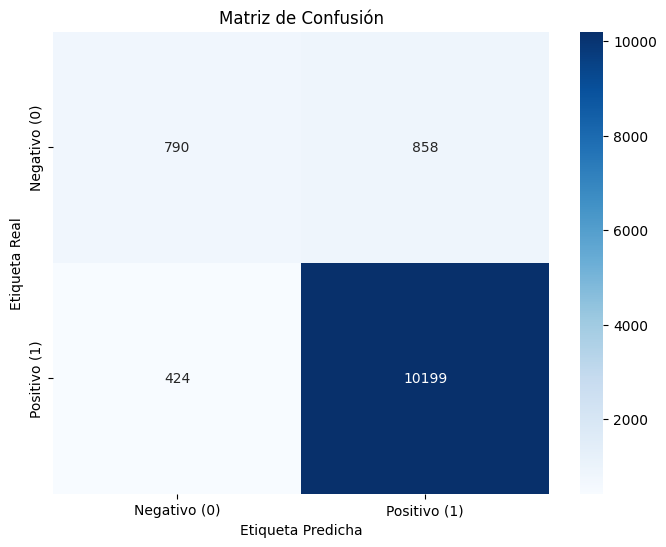

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluo el modelo y obtengo sus predicciones
predictions = model.predict(embeddings_test)

# Redondeo las predicciones a 0 o 1
predictions_rounded = np.round(predictions)

# Calculo la matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions_rounded)

# Visualizo la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Negativo (0)', 'Positivo (1)'], yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()



Cálculo las métricas de clasificación

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Elementos de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Precisión (accuracy)
accuracy = accuracy_score(y_test, predictions_rounded)

# Sensibilidad (recall)
recall = recall_score(y_test, predictions_rounded)

# Especificidad
specificity = tn / (tn + fp)

# F1-score
f1 = f1_score(y_test, predictions_rounded)

# Imprimo las métricas
print("Precisión (Accuracy):", accuracy)
print("Sensibilidad (Recall):", recall)
print("Especificidad (Specificity):", specificity)
print("F1-score:", f1)

Precisión (Accuracy): 0.8955260369977996
Sensibilidad (Recall): 0.9600866045373246
Especificidad (Specificity): 0.47936893203883496
F1-score: 0.9408671586715868


Los resultados obtenidos en este apartado son también interesante de comentar.

*   En primer lugar, se puede observar como el rendimiento del modelo para categoría 1 sigue siendo mejor que para categoría 2. Esto era algo que se podía suponer ya que aunque se haya utilizado otro modelo los datos están muy desbalanceados (el 87% son de categoría 1). Como consecuencia, se obtiene la misma conclusión que en el otro modelo y es que el modelo es bastante efectivo para clasificar la categoría 1 ya que el número de verdaderos positivos (10199) es significativamente mayor que el número de falsos negativos (424).

*  Además, el modelo parece seguir teniendo dificultades para clasificar la categoría 0, ya que el número de falsos positivos (858) es mayor que el número de verdaderos negativos (790).Sin embargo, se siga teniendo este problema, con el modelo LSTM la especificidad es supeior (0.47 frente a 0.32 que tenía el modelo anterior) por lo que esto lo que quiere indicar es que el modelo LSTM tiene una mejor capacidad para evitar clasificar incorrectamente los casos negativos como positivos.

Como resultado, es posible afirmar que el modelo LSTM sigue estando sesgado hacia la categoría 1 pero en contraposición presenta una mejor capacidad a la hora de clasificar incorrectamente los casos negativos como positivos. Por lo tanto, en caso de que se tuviera que utilizar uno de los, en mi opinión personal, yo elegiría el segundo por el hecho de que presente mejor rendimiento.

Por último, me gustaría acabar este apartado comentando que las conclusiones que se han obtenido en este apartado se han visto claramente influenciadas tanto por el desbalanceo de los datos (algo que ocurría también en el apartado anterior) como por la falta de recursos computacionales. No ha sido posible entrenar a los dos modelos con los mismos datos, por lo que esto es algo que hay que tener en cuenta a la hora de visualizar los resultados.